In [ ]:
#if you want to run this notebook in colab, to upload the train and test file, use this block of code
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm ,skew
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [2]:
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')

Data PreProcessing - Outlier Removal

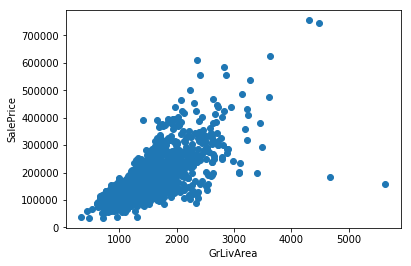

In [3]:
#There are 2 data points that shows very low SalePrice for bigger plots. We need to eliminate them.
fg,ax=plt.subplots()
ax.scatter(train['GrLivArea'],train['SalePrice'])
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()                            

In [4]:
train=train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

Analysis of Target Variable(SalePrice)


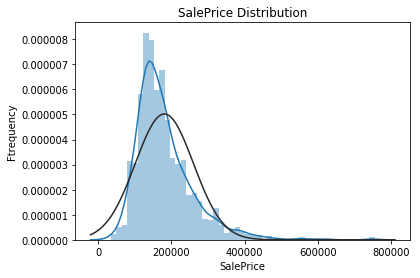

In [5]:
#Target Values are negatively skewed
sns.distplot(train['SalePrice'] , fit=norm)
plt.ylabel('Ftrequency')
plt.title("SalePrice Distribution")
plt.show()

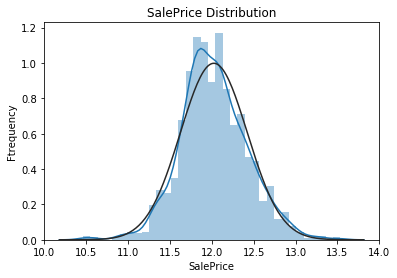

In [6]:
#Log Tranform the target variable to make it more normal
train['SalePrice']=np.log1p(train["SalePrice"])
sns.distplot(train['SalePrice'] , fit=norm)
plt.ylabel('Ftrequency')
plt.title("SalePrice Distribution")
plt.show()

Feature Engineering : Missing Data

In [7]:
# combining test and train data into a single DataFrame
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [8]:
NA_all_data = (all_data.isnull().sum())
NA_all_data = NA_all_data.drop(NA_all_data[NA_all_data == 0].index).sort_values(ascending=False)[:30]


Text(0.5, 1.0, 'Missing data of feature')

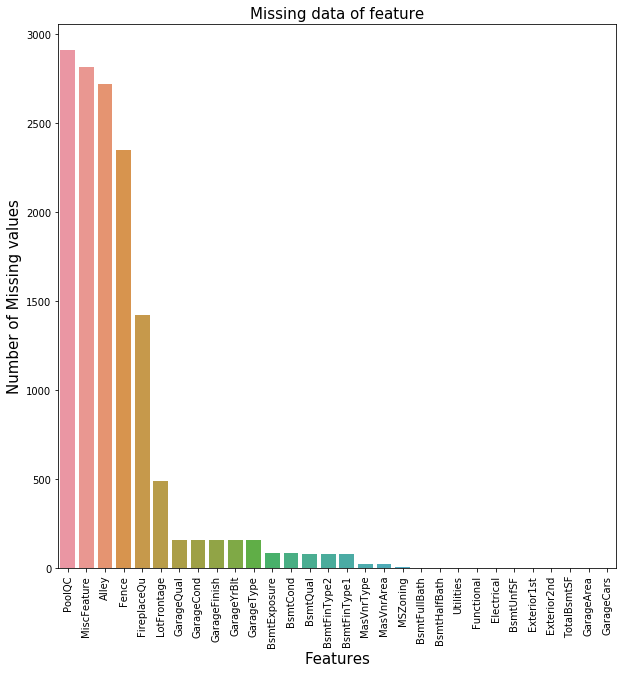

In [9]:
#Visual Representation of Missing Values.
f, ax = plt.subplots(figsize=(10, 10))
plt.xticks(rotation='90')
sns.barplot(x=NA_all_data.index, y=NA_all_data)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Number of Missing values', fontsize=15)
plt.title('Missing data of feature', fontsize=15)

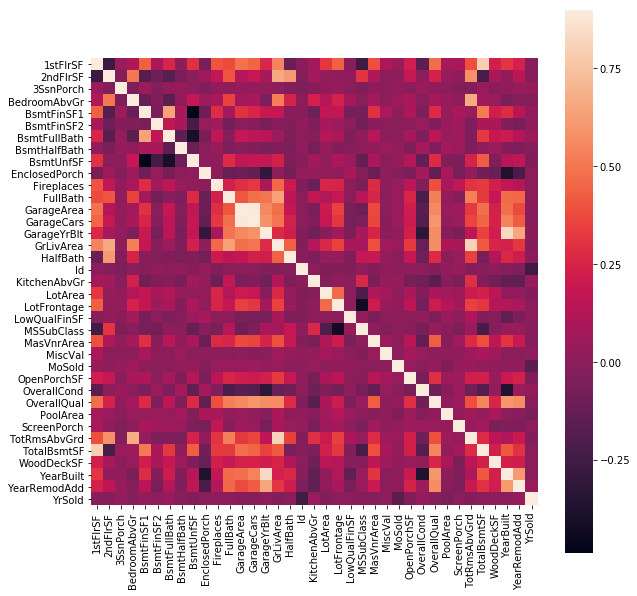

In [10]:
#correlation between features and SalesPrice
Correlation=all_data.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(Correlation,vmax=0.9, square=True)

Filling In Missing Values

In [11]:
#Fill in all the missing values in the increasing order of number of missing values
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data['LotFrontage']=all_data.groupby("Neighborhood")['LotFrontage'].transform(lambda x:x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data["Utilities"] = all_data["Utilities"].fillna("AllPub")
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [12]:
#Log Transforming Numeric features
numeric_index=all_data.dtypes[all_data.dtypes!='object'].index
skewed_features=all_data[numeric_index].apply(lambda x:skew(x)).sort_values(ascending=False)
skewed_features=skewed_features[abs(skewed_features)>0.5].index
all_data[skewed_features]=np.log1p(all_data[skewed_features])

In [13]:
#Getting dummy categorical features
all_data = pd.get_dummies(all_data)


Modelling:

In [14]:
#Prepare data for model
Xtrain=all_data[:train.shape[0]]
Xtest=all_data[train.shape[0]:]
y=train.SalePrice

In [15]:
# modules for Linear Regression and Regularization
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression,Ridge, RidgeCV, LassoCV, ElasticNetCV
scorer=make_scorer(mean_squared_error,greater_is_better = False)

def RMSE(model):
  rmse=np.sqrt(-cross_val_score(model,Xtrain,y,scoring=scorer,cv=10))
  return rmse
  

In [16]:
# Linear Regression without Regularization 
lr=LinearRegression()
lr.fit(Xtrain,y)
print("Validation Error for Linear Regression without Regularization  :{0}".format(RMSE(lr).mean()))

Validation Error for Linear Regression without Regularization  :0.13131393379532302


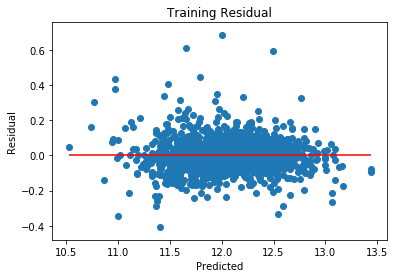

In [17]:
#plot The residuals. Most of the prediction are close to ground truth ie y=0 axis
train_pred=lr.predict(Xtrain)
plt.scatter(train_pred,train_pred-y)
plt.title("Training Residual")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.hlines(y = 0, xmin = train_pred.min(), xmax = train_pred.max() , color = "red")
plt.show()

Validation Error:0.11251439629640089


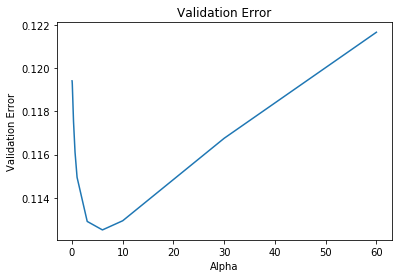

In [18]:
#Linear Regression with Ridge regularization (L2 penalty)
alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]
ridge=[RMSE(Ridge(alpha=alpha)).mean() for alpha in alphas]
ridge=pd.Series(ridge,index=alphas)
ridge.plot(title="Validation Error")
plt.xlabel("Alpha")
plt.ylabel("Validation Error")
print("Validation Error:{0}".format(ridge.min()))

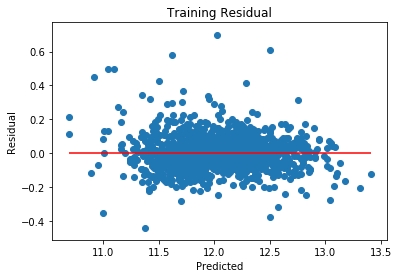

In [19]:
#Above plot shows 6 is the right choice for alpha
lr_L2=Ridge(alpha=6)
lr_L2.fit(Xtrain,y)
train_pred=lr_L2.predict(Xtrain)
plt.scatter(train_pred,train_pred-y)
plt.title("Training Residual")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.hlines(y = 0, xmin = train_pred.min(), xmax = train_pred.max() , color = "red")
plt.show()

In [20]:
#Linear Regression with Lasso regularization (L1 penalty)
lr_L1=LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1]).fit(Xtrain,y)
print("Validation Error:{0}".format(RMSE(lr_L1).mean()))

Validation Error:0.11124985346543763


Lasso Selected 132 features and eliminated 170


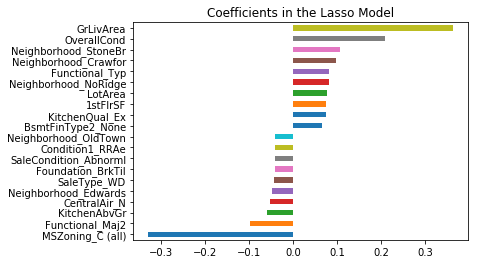

In [21]:
Selected_Coeff=pd.Series(lr_L1.coef_,index=Xtrain.columns)
print("Lasso Selected {0} features and eliminated {1}".format(sum(Selected_Coeff!=0),sum(Selected_Coeff==0)))
imp_coeff=pd.concat([Selected_Coeff.sort_values().head(10),Selected_Coeff.sort_values().tail(10)])
imp_coeff.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

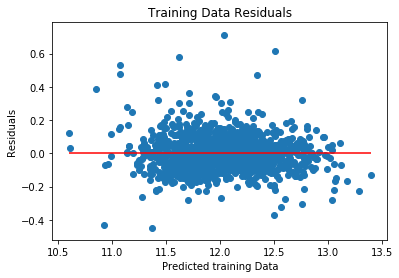

In [22]:
plt.scatter(lr_L1.predict(Xtrain),lr_L1.predict(Xtrain)-y)
plt.title("Training Data Residuals")
plt.xlabel("Predicted training Data")
plt.ylabel("Residuals")
plt.hlines(y = 0, xmin = lr_L1.predict(Xtrain).min(), xmax = lr_L1.predict(Xtrain).max() , color = "red")
plt.show()